# 데이터 전처리

- 기존데이터에 평균기온(°C), 일강수량(mm), 평균 지면온도(°C), 확진자수 피처가 추가된 데이터 사용

In [1]:
import pandas as pd
import numpy as np
import warnings 
import os
import holidays
import datetime
from datetime import timedelta



from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.font_manager as fm
matplotlib.rcParams['axes.unicode_minus'] = False


# plt.rc('font', family=fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name())
plt.rc('font', family='AppleGothic')

plt.style.use('fivethirtyeight')

In [70]:
# 사용자 운영체제 확인
import os
os.name

# 운영체제별 한글 폰트 설정
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

In [3]:
# # 재민

# from google import colab
# colab.drive.mount("/content/drive")

# data = "/content/drive/MyDrive/colab/cook/"

# sub = pd.read_csv(f'{data}sample_submission.csv')
# train = pd.read_csv(f'{data}weather_corona_train.csv', encoding='cp949', index_col = 0)
# test = pd.read_csv(f'{data}weather_corona_test.csv', encoding='cp949', index_col = 0)

In [4]:
# # 효진
# train = pd.read_csv('/Users/hyojin/Desktop/miniProject/weather_corona_train.csv', encoding='cp949', index_col = 0)
# test = pd.read_csv('/Users/hyojin/Desktop/miniProject/weather_corona_test.csv', encoding='cp949', index_col = 0)
# sub = pd.read_csv('/Users/hyojin/Desktop/miniProject/sample_submission.csv')

In [5]:
# 태남
train = pd.read_csv('./data/weather_corona_train.csv', encoding='cp949', index_col = 0)
test = pd.read_csv('./data/weather_corona_test.csv', encoding='cp949', index_col = 0)
sub = pd.read_csv('./data/sample_submission.csv')

In [6]:
## 필요없는거 일단 지우기
train = train.drop(['평균 지면온도(°C)','확진자수','조식메뉴'],axis=1)
test = test.drop(['평균 지면온도(°C)','확진자수','조식메뉴'],axis=1)

In [7]:
## 열 이름이 지저분해서 변경
train.rename(columns={'평균기온(°C)':'평균기온','일강수량(mm)':'일강수량'},inplace=True)
test.rename(columns={'평균기온(°C)':'평균기온','일강수량(mm)':'일강수량'},inplace=True)

## 기온 피쳐

- 평균기온(°C) -> 영하는 1, 영상은 0으로 변경

In [8]:
## 659인덱스가 널값이라서 양 옆 기온 확인
print(train['평균기온'][658],train['평균기온'][660])

12.4 12.6


In [9]:
# 양옆기온의 평균으로 결측치 채우기
train['평균기온'][659]=12.5

In [10]:
## 테스트데이터가 1~2월이기에 영하의 온도를 체크할 필요가 있어보임
## 온도가 영하면 1, 영상이면 0으로 기온피쳐를 변경

def cold(x):
    if x<0:
        return 1
    else:
        return 0

train['평균기온'] = train['평균기온'].apply(cold)
test['평균기온'] = test['평균기온'].apply(cold)

In [11]:
## 중식은 영하온도면 더 먹고, 석식은 영하면 덜먹음  영하면 집에 빨리가나..?

print('영하 중식계:',train.loc[train['평균기온']==1,'중식계'].mean(),
     '영하 석식계: ',train.loc[train['평균기온']==1,'석식계'].mean(),'\n',
     '영상 중식계: ',train.loc[train['평균기온']==0,'중식계'].mean(),
     '영상 석식계: ', train.loc[train['평균기온']==0,'석식계'].mean())

영하 중식계: 917.7386363636364 영하 석식계:  424.2386363636364 
 영상 중식계:  888.1754700089525 영상 석식계:  464.7296329453894


## 강수량 피쳐

- 일강수량(mm) -> 비 내린 날 1, 비 안 내린 날 0

In [12]:
# 널값은 0으로 채우자
train['일강수량']=train['일강수량'].fillna(0)
test['일강수량']=test['일강수량'].fillna(0)

In [13]:
# 비가 안오면 0, 비가 온날은 1로 강수량 피쳐 변경
def rain(x):
    if x==0:
        return 0
    else:
        return 1

train['일강수량'] = train['일강수량'].apply(rain)
test['일강수량'] = test['일강수량'].apply(rain)

In [14]:
## 비가 올때 중,석식 다 많이 먹음 (차이는 중식이 더 큼)

print('비o 중식계:',train.loc[train['일강수량']==1,'중식계'].mean(),
     '비o 석식계: ',train.loc[train['일강수량']==1,'석식계'].mean(),'\n',
     '비x 중식계: ',train.loc[train['일강수량']==0,'중식계'].mean(),
     '비x 석식계: ', train.loc[train['일강수량']==0,'석식계'].mean())

비o 중식계: 924.0291262135922 비o 석식계:  463.1618122977346 
 비x 중식계:  878.7142857142857 비x 석식계:  461.2935267857143


## 날짜 피쳐 생성

- 공휴일전 : 공휴일 전날은 1, 아니면 0
- 공휴일후 : 공휴일 다음 날은 1, 아니면 0

In [15]:
holiday_list = [] 
for i in range(2016,2022):
    for date in holidays.KR(years=i).keys():  # 한국 공휴일 가져오기
        holiday_list.append(date)

In [16]:
holiday_before_list=[]
for_mat='%Y-%m-%d'
for i in holiday_list:
    holiday_before_list.append((i - timedelta(days=1)).strftime(for_mat))
        # i - timedelta(days=1): datetime에서 날짜 하루 빼기
        # .strftime(for_mat): 포맷과 같은 형식으로 datetime에서 str로 변환

In [17]:
def holiday_before(x):
    if x in holiday_before_list:
        return 1
    else:
        return 0
train['공휴일전'] = train.일자.apply(holiday_before)
test['공휴일전'] = test.일자.apply(holiday_before)

In [18]:
holiday_after_list=[]
for_mat='%Y-%m-%d'
for i in holiday_list:
    holiday_after_list.append((i + timedelta(days=1)).strftime(for_mat))

In [19]:
def holiday_after(x):
    if x in holiday_after_list:
        return 1
    else:
        return 0
train['공휴일후'] = train.일자.apply(holiday_after)
test['공휴일후'] = test.일자.apply(holiday_after)

In [20]:
## 누락된 것은 찾아서 넣음

# 16-4-13 국회의원 선거
train['공휴일전'][47]=1
train['공휴일후'][48]=1

# 17-5-9 대통령 선거
train['공휴일전'][311]=1
train['공휴일후'][312]=1

# 18-6-13 지방선거
train['공휴일전'][579]=1
train['공휴일후'][580]=1

# 20-4-15 국회의원 선거
train['공휴일전'][1027]=1
train['공휴일후'][1028]=1

# 20-9-30 추석
train['공휴일전'][1129]=1


- 요일 : 레이블 인코딩

In [21]:
train.일자 = train.일자.astype('datetime64')
test.일자 = test.일자.astype('datetime64')

In [22]:
train['월'] = train.일자.dt.month
train['일'] = train.일자.dt.day

test['월'] = test.일자.dt.month
test['일'] = test.일자.dt.day

In [23]:
def dayofweek1(x):
    if '월' in x:
        return 1
    elif "화" in x:
        return 2
    elif "수" in x:
        return 3
    elif "목" in x:
        return 4
    else:
        return 5

train['요일'] = train.요일.apply(dayofweek1)
test['요일'] = test.요일.apply(dayofweek1)

- 요일_야근 : 석식의 경우 평균 석식계가 낮은 수, 금에 1값 부여, 나머지는 0

In [24]:
## 석식계의 수, 금이 낮은 경향
## 수,금요일은 1, 아닌날은 0인 피쳐 생성
## 아마 이 피쳐는 석식에만 넣어도 될듯?

def dayofweek2(x):
    if x in [3,5]:
        return 1
    else:
        return 0

train['요일_야근'] = train.요일.apply(dayofweek2)
test['요일_야근'] = test.요일.apply(dayofweek2)

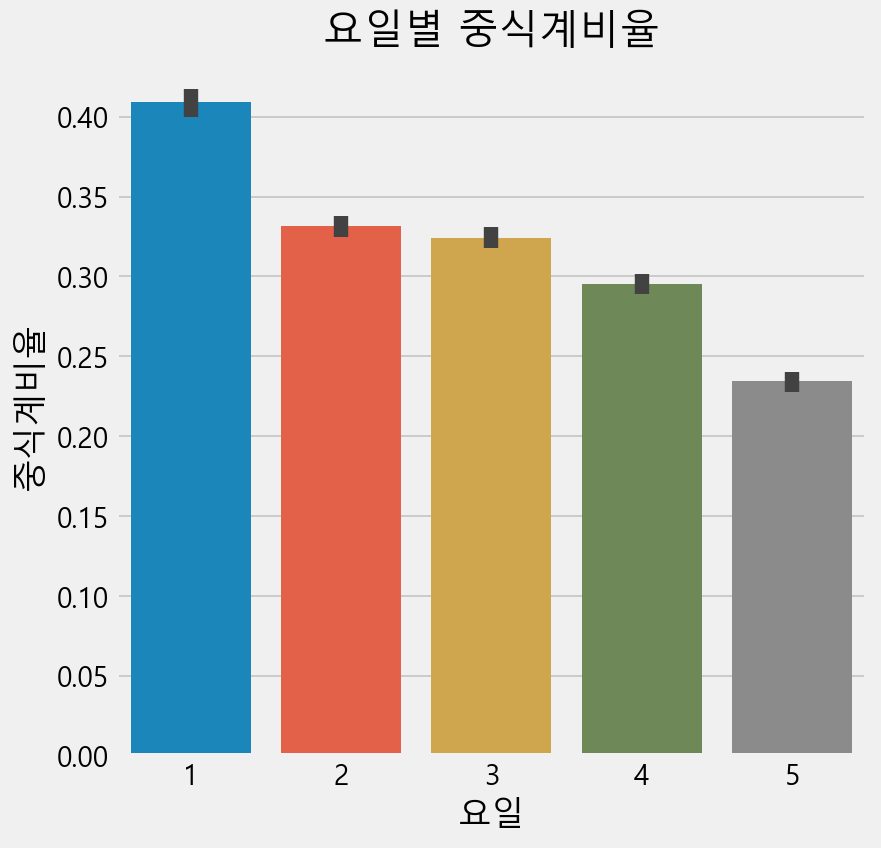

In [77]:
plt.figure(figsize=(6,6))

sns.barplot(x="요일", y="중식계비율", data=train)
plt.title("요일별 중식계비율")
plt.show()

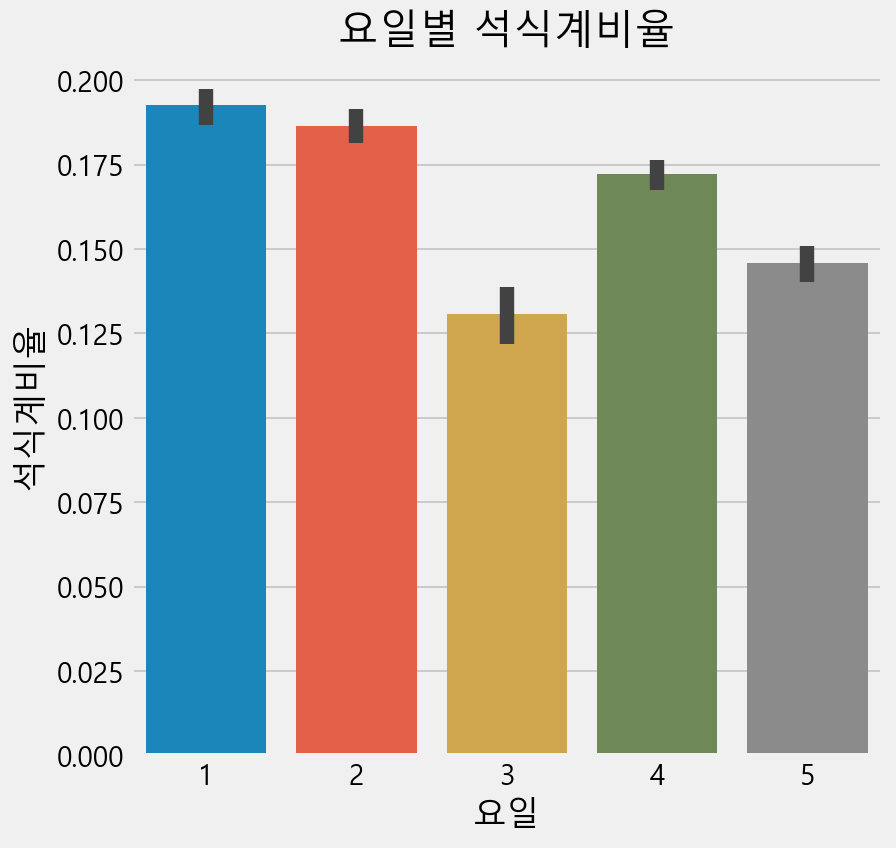

In [78]:
plt.figure(figsize=(6,6))

sns.barplot(x="요일", y="석식계비율", data=train)
plt.title("요일별 석식계비율")
plt.show()

- 일_초중말 : 월 초반, 중반, 말을 10일 단위로 구분

In [25]:
## 10, 20, 31 기준으로 일 초, 중, 말을 표현하는 피쳐생성
def dayofweek3(x):
    if x < 11:
        return 1
    elif x < 21:
        return 2
    else:
        return 3

train['일_초중말'] = train.일.apply(dayofweek3)
test['일_초중말'] = test.일.apply(dayofweek3)

## 인원 피쳐

- 출근 : 본사정원수 - 본사출장자수 - 본사휴가자수 - 현본사소속재택근무
- 휴가비율 : 본사휴가자수 / 본사정원수
- 출장비율 : 본사출장자수 / 본사정원수
- 야근비율 : 본사시간외근무 / 본사정원수
- 재택비율 : 현본사재택근무 / 본사정원수

In [26]:
train['출근'] = train['본사정원수'] - train['본사출장자수'] - train['본사휴가자수'] - train['현본사소속재택근무자수']
test['출근'] = test['본사정원수'] - test['본사출장자수'] - test['본사휴가자수'] - test['현본사소속재택근무자수']

train['휴가비율'] = train['본사휴가자수']/train['본사정원수']
test['휴가비율'] = test['본사휴가자수']/test['본사정원수']

train['출장비율'] = train['본사출장자수']/train['본사정원수']
test['출장비율'] = test['본사출장자수']/test['본사정원수']

train['야근비율'] = train['본사시간외근무명령서승인건수']/train['출근']
test['야근비율'] = test['본사시간외근무명령서승인건수']/test['출근']

train['재택비율'] = train['현본사소속재택근무자수']/train['본사정원수']
test['재택비율'] = test['현본사소속재택근무자수']/test['본사정원수']

## 메뉴정리(중식)
- 밥_중식
- 국_중식
- 반찬_중식
=> 모두 레이블 인코딩

In [27]:
#메뉴 구분 함수
def split_menu(x):
  menu_return = []  #return할 메뉴 데이터. 메뉴 스플릿 & 원산지 제외
  for data in x:
    menus = []              #전처리된 메뉴
    menus_sp = data.split() #띄어쓰기 split
    for menu_sp in menus_sp:
      if '(' in menu_sp:
        pass
      elif ',' in menu_sp:  #comma split
        menus_comma = menu_sp.split(',')
        for menu_comma in menus_comma:
          menus.append(menu_comma)
      else:
        menus.append(menu_sp)
    menu_return.append(menus)
  return menu_return
#train 데이터 중식메뉴 카테고리별 분류
def seperate_lunch_menu_list(df):

  str = 'None'
  lunch_menu_list = df['중식메뉴리스트']

  print('######## 점심 데이터 구분 함수 시작 ########')

  #메뉴 종류별 구분 (10 피처)
  rice = []
  soup = []
  side_1 = []
  side_2 = []
  side_3 = []
  side_4 = []
  side_5 = []
  dessert_1 = []
  dessert_2 = []
  kimchi = []

  for idx, lunch_menu in enumerate(lunch_menu_list):

    # print("현재 인덱스 :", idx)
    # print(lunch_menu)

    #[밥 국 반찬2개 디저트 김치]
    if idx in [38,57,70,75,80,109,123,286,301,341,
                 361,366,449,482,549,553,687,747,786,843,
                 867,882,909,983,1023,1061]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[4])
      dessert_2.append(str)
      kimchi.append(lunch_menu[5])
    #[밥 국 반찬3개 디저트 김치]
    elif idx in [0,1,2,3,4,5,6,7,8,9,
               11,12,13,15,16,17,19,169,378,705,
               951,956,1062,1064,1066]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[5])
      dessert_2.append(str)
      kimchi.append(lunch_menu[6])
    #[밥 국 반찬3개 디저트2개 김치]
    elif idx in [1026,1035,1040,1042,1045]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[5])
      dessert_2.append(lunch_menu[6])
      kimchi.append(lunch_menu[7])       
    #[밥 국 반찬4개 디저트 김치]
    elif idx in [1027,1032,1033,1034,1039,1041,1044,1046]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(lunch_menu[5])
      side_5.append(str)
      dessert_1.append(lunch_menu[6])
      dessert_2.append(str)
      kimchi.append(lunch_menu[7])      
    #[밥 국 반찬5개 김치]
    elif idx in [1043]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(lunch_menu[5])
      side_5.append(lunch_menu[6])
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[7])        
    #[밥 국 반찬2개 김치]
    elif idx in [223,289,1036]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[4])
    #[밥 국 반찬4개 김치]
    elif idx in [373,873,1007,1029,1030]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(lunch_menu[5])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[6])
    #[밥 국 반찬2개 반찬/디저트 김치]
    elif idx in [119,155,189,209,351,471,492,614,648,654,
                 720,742,872,907,914,924,929,937,979,1020,
                 1021]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4].split('/')[0])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[4].split('/')[1])
      dessert_2.append(str)
      kimchi.append(lunch_menu[5])
    #[밥 반찬3개 김치]
    elif idx in [175,288]:   
      rice.append(lunch_menu[0])
      soup.append(str)
      side_1.append(lunch_menu[1])
      side_2.append(lunch_menu[2])
      side_3.append(lunch_menu[3])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[4])     
    #[밥 반찬3개 디저트2개 김치]
    elif idx in [1037]:   
      rice.append(lunch_menu[0])
      soup.append(str)
      side_1.append(lunch_menu[1])
      side_2.append(lunch_menu[2])
      side_3.append(lunch_menu[3])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[4])
      dessert_2.append(lunch_menu[5])
      kimchi.append(lunch_menu[6])        
    #특이 케이스
    elif idx in [10]:   #[밥 국 반찬2개 디저트(중복2개) 김치]
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[4])
      dessert_2.append(str)
      kimchi.append(lunch_menu[6])
    elif idx in [14]:   #[밥 국 반찬2개 디저트2개 김치]
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[4])
      dessert_2.append(lunch_menu[5])
      kimchi.append(lunch_menu[6])
    elif idx in [116,400,459]:     #[밥 국 반찬2개 디저트/반찬 김치]
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4].split('/')[1])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[4].split('/')[0])
      dessert_2.append(str)
      kimchi.append(lunch_menu[5])  
    elif idx in [412,650]:     #[밥 국 반찬/반찬 반찬 디저트/디저트 김치]
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2].split('/')[0])
      side_2.append(lunch_menu[2].split('/')[1])
      side_3.append(lunch_menu[3])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[4].split('/')[0])
      dessert_2.append(lunch_menu[4].split('/')[1])
      kimchi.append(lunch_menu[5])  
    elif idx in [934]:     #[밥 국 반찬2개 디저트/디저트 김치]   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[4].split('/')[0])
      dessert_2.append(lunch_menu[4].split('/')[1])
      kimchi.append(lunch_menu[5])  
    #[밥 국 반찬3개 디저트 김치]
    elif idx in [356,840]:     #[<초복특식> 국 밥 반찬 디저트 김치]  
      rice.append(lunch_menu[2])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[3])
      side_2.append(str)
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[4])
      dessert_2.append(str)
      kimchi.append(lunch_menu[5])  
    elif idx in [603]:     #[국 밥 반찬2개 디저트 김치]  
      rice.append(lunch_menu[1])
      soup.append(lunch_menu[0])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[4])
      dessert_2.append(str)
      kimchi.append(lunch_menu[5])  
    elif idx in [1031]:     #[밥 국 반찬5개 디저트 김치]  
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(lunch_menu[5])
      side_5.append(lunch_menu[6])
      dessert_1.append(lunch_menu[7])
      dessert_2.append(str)
      kimchi.append(lunch_menu[8])  
    elif idx in [511,741,980]:     #[밥 국 반찬3개 디저트/김치]  
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[5].split('/')[0])
      dessert_2.append(str)
      kimchi.append(lunch_menu[5].split('/')[1])  
    #이상 케이스
    elif idx in [885]:     #[밥 국 반찬3개 ' /오렌지주스' 김치/디저트]  
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[5].split('/')[1])
      dessert_2.append(lunch_menu[6].split('/')[1])
      kimchi.append(lunch_menu[6].split('/')[0])  
    elif idx in [1038]:     #[밥 국 반찬4개 청,적포도 디저트 김치]  
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(lunch_menu[5])
      side_5.append(str)
      dessert_1.append('청,적포도')
      dessert_2.append(lunch_menu[8])
      kimchi.append(lunch_menu[9]) 
    elif idx in [1026]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[5].split(',')[0])
      dessert_2.append(lunch_menu[5].split(',')[0])
    #[밥 국 반찬3개 김치 반찬]
    elif idx in [1067,1068,1069,1070,1071,1073,1074,1075,1076,1077,
                 1078,1079,1080,1081,1082,1083,1084,1085,1086,1088,
                 1089,1090,1091,1094,1095,1097,1098,1099,1100,1101,
                 1104,1108,1112,1116,1117,1125,1126,1128,1130,1138,
                 1143,1145,1148,1150,1152,1153,1157,1162,1163,1176,
                 1177,1178,1180,1183,1191,1192,1193,1195,1196,1197,
                 1199,1200,1201,1202]:       
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(lunch_menu[6])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[5]) 
    #[밥 국 반찬3개 김치 디저트]
    elif idx in [1131]:       
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[6])
      dessert_2.append(str)
      kimchi.append(lunch_menu[5])       
    #[밥 국 반찬3개 김치/디저트 반찬]
    elif idx in [1096,1102,1103,1110,1113,1114,1115,1119,1120,1124,
                 1127,1132,1134,1135,1139,1140,1144,1155,1156,1158,
                 1159,1161,1166,1169,1170,1174,1175,1184,1185,1188,
                 1198,1204]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(lunch_menu[6])
      side_5.append(str)
      dessert_1.append(lunch_menu[5].split('/')[1])
      dessert_2.append(str)
      kimchi.append(lunch_menu[5].split('/')[0]) 
    #[밥 국 반찬3개 김치/디저트/디저트 반찬]
    elif idx in [1129]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(lunch_menu[6])
      side_5.append(str)
      dessert_1.append(lunch_menu[5].split('/')[1])
      dessert_2.append(lunch_menu[5].split('/')[2])
      kimchi.append(lunch_menu[5].split('/')[0]) 
    #[밥 국 반찬3개 김치 반찬/디저트]
    elif idx in [1107]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(lunch_menu[6].split('/')[0])
      side_5.append(str)
      dessert_1.append(lunch_menu[6].split('/')[1])
      dessert_2.append(str)
      kimchi.append(lunch_menu[5]) 
    #[밥 국 반찬3개 김치 디저트/반찬]
    elif idx in [1107]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(lunch_menu[6].split('/')[1])
      side_5.append(str)
      dessert_1.append(lunch_menu[6].split('/')[0])
      dessert_2.append(str)
      kimchi.append(lunch_menu[5]) 
    #[밥 국 반찬2개 김치/반찬 반찬]
    elif idx in [1141]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4].split('/')[1])
      side_4.append(lunch_menu[5])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[4].split('/')[0])  
    #[밥 국 반찬3개 김치/반찬 반찬]
    elif idx in [1160,1190,1203]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(lunch_menu[5].split('/')[1])
      side_5.append(lunch_menu[6])
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[5].split('/')[0])       
    #[밥 국 반찬3개 김치/반찬]
    elif idx in [94]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(lunch_menu[5].split('/')[1])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[5].split('/')[0])       
    #[밥 국 반찬3개 반찬/김치 반찬]
    elif idx in [1189]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(lunch_menu[5].split('/')[0])
      side_5.append(lunch_menu[6])
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[5].split('/')[1])    
    #[밥 국 반찬2개 김치/디저트 반찬]
    elif idx in [1109,1149,1164]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[5])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[4].split('/')[1])
      dessert_2.append(str)
      kimchi.append(lunch_menu[4].split('/')[0]) 
    #[밥 국 반찬3개 김치/디저트 반찬]
    elif idx in [1092]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(lunch_menu[6])
      side_5.append(str)
      dessert_1.append(lunch_menu[5].split('/')[1])
      dessert_2.append(str)
      kimchi.append(lunch_menu[5].split('/')[0])       
    #[밥 국 반찬 반찬/반찬 반찬 김치/디저트 반찬]
    elif idx in [1093]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3].split('/')[0])
      side_3.append(lunch_menu[3].split('/')[1])
      side_4.append(lunch_menu[4])
      side_5.append(lunch_menu[6])
      dessert_1.append(lunch_menu[5].split('/')[1])
      dessert_2.append(str)
      kimchi.append(lunch_menu[5].split('/')[0]) 

    #[밥 국 반찬2개 반찬/김치 반찬]
    elif idx in [1146,1154]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4].split('/')[0])
      side_4.append(lunch_menu[5])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[4].split('/')[1]) 
    #[밥 국 반찬2개 김치 반찬]
    elif idx in [1118,1121,1122,1123,1133,1136,1165,1167,1173,1194]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[5])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[4]) 
    #[밥 국 반찬 김치 반찬]
    elif idx in [1186]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[4])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[3])
    #[밥 국 반찬4개]
    elif idx in [1019,1137]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(lunch_menu[5])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(str)
    #[밥 국 반찬3개]
    elif idx in [1151]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(str)
    #[밥 반찬2개 김치/디저트 반찬]
    elif idx in [1111,1179]:   
      rice.append(lunch_menu[0])
      soup.append(str)
      side_1.append(lunch_menu[1])
      side_2.append(lunch_menu[2])
      side_3.append(lunch_menu[4])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[3].split('/')[1])
      dessert_2.append(str)
      kimchi.append(lunch_menu[3].split('/')[0])    
    elif idx in [1142]:   
      rice.append(lunch_menu[0]+lunch_menu[1])
      soup.append(lunch_menu[2])
      side_1.append(lunch_menu[3])
      side_2.append(lunch_menu[4])
      side_3.append(lunch_menu[5])
      side_4.append(lunch_menu[6].split('/')[1])
      side_5.append(lunch_menu[7])
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[6].split('/')[0]) 
    elif idx in [1087]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(lunch_menu[5].split('/')[0])
      side_5.append(lunch_menu[6])
      dessert_1.append(lunch_menu[5].split('/')[2])
      dessert_2.append(str)
      kimchi.append(lunch_menu[5].split('/')[1]) 
    #[밥 반찬3개 김치/디저트 반찬]
    elif idx in [1147]:   
      rice.append(lunch_menu[0])
      soup.append(str)
      side_1.append(lunch_menu[1])
      side_2.append(lunch_menu[2])
      side_3.append(lunch_menu[3])
      side_4.append(lunch_menu[5])
      side_5.append(str)
      dessert_1.append(lunch_menu[4].split('/')[1])
      dessert_2.append(str)
      kimchi.append(lunch_menu[4].split('/')[0]) 
    elif idx in [1168]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4]+' '+lunch_menu[5])
      side_4.append(lunch_menu[7])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[6]) 
    #[국 반찬2개 반찬/김치 반찬]  
    elif idx in [1171]:   
      rice.append(str)
      soup.append(lunch_menu[0])
      side_1.append(lunch_menu[1])
      side_2.append(lunch_menu[2])
      side_3.append(lunch_menu[3].split('/')[0])
      side_4.append(lunch_menu[4])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[3].split('/')[1])  
    #[밥 반찬3개 김치 반찬]  
    elif idx in [1181]:   
      rice.append(lunch_menu[0])
      soup.append(str)
      side_1.append(lunch_menu[1])
      side_2.append(lunch_menu[2])
      side_3.append(lunch_menu[3])
      side_4.append(lunch_menu[5])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[4])     
    #[밥 반찬2개 김치 반찬]  
    elif idx in [1182]:   
      rice.append(lunch_menu[0])
      soup.append(str)
      side_1.append(lunch_menu[1])
      side_2.append(lunch_menu[2])
      side_3.append(lunch_menu[4])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[3])    
    #[국 반찬3개 김치 반찬]  
    elif idx in [1182,1187]:   
      rice.append(str)
      soup.append(lunch_menu[0])
      side_1.append(lunch_menu[1])
      side_2.append(lunch_menu[2])
      side_3.append(lunch_menu[3])
      side_4.append(lunch_menu[5])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[4])      
    elif idx in [762]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[5])
      dessert_2.append(lunch_menu[6]+'/'+lunch_menu[7])
      kimchi.append(lunch_menu[8])          
    else:   #[밥 국 반찬3개 김치]
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[5])

  print('######## 점심 데이터 구분 함수 종료 ########')

  return rice, soup, side_1, side_2, side_3, side_4, side_5, dessert_1, dessert_2, kimchi
#train 데이터 석식메뉴 카테고리별 분류
def seperate_dinner_menu_list(df):

  str = 'None'
  dinner_menu_list = df['석식메뉴리스트']

  print('######## 저녁 데이터 구분 함수 시작 ########')

  #메뉴 종류별 구분 (10 피처)
  rice = []
  soup = []
  side_1 = []
  side_2 = []
  side_3 = []
  side_4 = []
  side_5 = []
  dessert_1 = []
  dessert_2 = []
  kimchi = []

  for idx, dinner_menu in enumerate(dinner_menu_list):

    # print("현재 인덱스 :", idx)
    # print(dinner_menu)

    #[밥 국 반찬2개 디저트 김치]
    if idx in [1,9,11,34,37,47,48,64,66,71,74,81,85,88,100,124,
               134,144,154,170,173,188,203,220,228,230,238,240,
               253,258,261,287,302,321,332,340,352,355,367,381,
               386,404,435,455,473,481,486,488,493,496,513,523,
               525,535,548,550,570,580,588,593,600,608,610,624,
               629,639,647,653,656,678,683,686,693,701,726,729,
               741,760,777,782,819,832,834,842,847,852,859,873,
               901,906,921,946,952,966,1017,1042,1055,1065,110]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[4])
      dessert_2.append(str)
      kimchi.append(dinner_menu[5])
    #[밥 국 반찬2개 반찬/디저트 김치]
    elif idx in [29,103,105,120,137,178,193,201,213,223,251,
                 256,280,285,296,297,300,305,310,318,320,328,342,
                 384,399,407,411,416,443,456,458,474,509,516,536,
                 540,545,563,590,605,632,642,661,663,703,716,719,
                 731,736,738,743,750,752,755,757,770,775,787,795,
                 798,803,808,813,822,854,866,876,886,891,913,943,
                 948,984,1009,1014,1155]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(dinner_menu[4].split('/')[0])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[4].split('/')[1])
      dessert_2.append(str)
      kimchi.append(dinner_menu[5])    
    #[밥 국 반찬2개 디저트/반찬 김치]
    elif idx in [53,56,98,190,233,362,530,561,567,572,765,767,898,326]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(dinner_menu[4].split('/')[1])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[4].split('/')[0])
      dessert_2.append(str)
      kimchi.append(dinner_menu[5]) 
    #[밥 국 반찬2개 디저트/디저트 김치]
    elif idx in [62,69,113,132,246,267,483,964,1063]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[4].split('/')[0])
      dessert_2.append(dinner_menu[4].split('/')[1])
      kimchi.append(dinner_menu[5]) 
    #[밥 국 반찬2개 김치]
    elif idx in [214,273,1087,1094,1115,1119,1124,1127,1130,1131,1138,
                 1145,1148,1152,1156,1169,1180,1182,1191,565]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[4]) 
    #[밥 국 반찬2개 김치/반찬]
    elif idx in [1143]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(dinner_menu[4].split('/')[1])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[4].split('/')[0]) 
    #[밥 국 반찬3개 디저트 김치]
    elif idx in [225,373,620,627,951,1038,1039,1041]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(dinner_menu[4])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[5])
      dessert_2.append(str)
      kimchi.append(dinner_menu[6]) 
    #[밥 국 반찬3개 김치/반찬]
    elif idx in [49,1141]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(dinner_menu[4])
      side_4.append(dinner_menu[5].split('/')[1])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[5].split('/')[0]) 
    #[밥 국 반찬3개 김치/디저트]
    elif idx in [1105,1111,1117]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(dinner_menu[4])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[5].split('/')[1])
      dessert_2.append(str)
      kimchi.append(dinner_menu[5].split('/')[0])
    #[밥 국 반찬4개 김치]
    elif idx in [331,394,396,1031,1032,1035,1037,1043,1068]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(dinner_menu[4])
      side_4.append(dinner_menu[5])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[6])
    #[밥 국 반찬4개 디저트 김치]
    elif idx in [971]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(dinner_menu[4])
      side_4.append(dinner_menu[5])
      side_5.append(str)
      dessert_1.append(dinner_menu[6])
      dessert_2.append(str)
      kimchi.append(dinner_menu[7])
    #[밥 반찬 국 반찬 디저트 김치]
    elif idx in [58]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[2])
      side_1.append(dinner_menu[1])
      side_2.append(dinner_menu[3])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[4])
      dessert_2.append(str)
      kimchi.append(dinner_menu[5])
    #[밥 국 반찬 반찬/디저트 반찬 김치]
    elif idx in [128,130,208]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3].split('/')[0])
      side_3.append(dinner_menu[4])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[3].split('/')[1])
      dessert_2.append(str)
      kimchi.append(dinner_menu[5])
    #[밥 국 반찬/디저트 반찬2개 김치]
    elif idx in [185]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2].split('/')[0])
      side_2.append(dinner_menu[3])
      side_3.append(dinner_menu[4])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[2].split('/')[1])
      dessert_2.append(str)
      kimchi.append(dinner_menu[5])
    #[밥 국 반찬 디저트/디저트 반찬 김치]
    elif idx in [215]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[4])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[3].split('/')[0])
      dessert_2.append(dinner_menu[3].split('/')[1])
      kimchi.append(dinner_menu[5])
    #[밥 국 반찬 디저트 디저트/반찬 김치]
    elif idx in [270]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[4].split('/')[1])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[3])
      dessert_2.append(dinner_menu[4].split('/')[0])
      kimchi.append(dinner_menu[5])
    #[밥/국 반찬4개 김치]
    elif idx in [93]:   
      rice.append(dinner_menu[0].split('/')[0])
      soup.append(dinner_menu[0].split('/')[1])
      side_1.append(dinner_menu[1])
      side_2.append(dinner_menu[2])
      side_3.append(dinner_menu[3])
      side_4.append(dinner_menu[4])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[5])
    #[국 밥 반찬2개 디저트 김치]
    elif idx in [345]:   
      rice.append(dinner_menu[1])
      soup.append(dinner_menu[0])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[4])
      dessert_2.append(str)
      kimchi.append(dinner_menu[5])
    #[밥 반찬 국 반찬2개 디저트 김치]
    elif idx in [391]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[2])
      side_1.append(dinner_menu[1])
      side_2.append(dinner_menu[3])
      side_3.append(dinner_menu[4])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[5])
      dessert_2.append(str)
      kimchi.append(dinner_menu[6])
    #[밥 국 반찬 김치]
    elif idx in [1172]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(str)
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[3])
    #[밥 국 반찬 디저트 김치]
    elif idx in [528,790]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(str)
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[3])
      dessert_2.append(str)
      kimchi.append(dinner_menu[4])
    #[밥 국 반찬 디저트 디저트 김치]
    elif idx in [1013]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(str)
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[3])
      dessert_2.append(dinner_menu[4])
      kimchi.append(dinner_menu[5])
    #[밥 국 반찬 디저트 반찬 김치]
    elif idx in [44,151,161,335,453,3,19]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[4])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[3])
      dessert_2.append(str)
      kimchi.append(dinner_menu[5])
    #[밥 국 반찬 x 반찬2개 김치]
    elif idx in [15]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[4])
      side_3.append(dinner_menu[5])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[6])
    #[]
    elif idx in [95]:   
      rice.append(dinner_menu[1])
      soup.append(dinner_menu[2])
      side_1.append(dinner_menu[3])
      side_2.append(dinner_menu[4].split('/')[0])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[4].split('/')[1])
      dessert_2.append(str)
      kimchi.append(dinner_menu[5])
    #[밥 반찬2개 디저트/반찬 김치]
    elif idx in [506]:   
      rice.append(dinner_menu[0])
      soup.append(str)
      side_1.append(dinner_menu[1])
      side_2.append(dinner_menu[2])
      side_3.append(dinner_menu[3].split('/')[1])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[3].split('/')[0])
      dessert_2.append(str)
      kimchi.append(dinner_menu[4])
    #[국 밥 반찬 반찬/디저트 김치]
    elif idx in [780]:   
      rice.append(dinner_menu[1])
      soup.append(dinner_menu[0])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3].split('/')[0])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[3].split('/')[1])
      dessert_2.append(str)
      kimchi.append(dinner_menu[4])
    #[]
    elif idx in [1010]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[5])
      side_3.append(dinner_menu[6])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[7])
    #[]
    elif idx in [1027]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[3])
      side_1.append(dinner_menu[1]+ ' '+dinner_menu[2])
      side_2.append(dinner_menu[4])
      side_3.append(dinner_menu[5])
      side_4.append(dinner_menu[6])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[7])
    #[]
    elif idx in [1048]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append('배')
      dessert_2.append(dinner_menu[5])
      kimchi.append(dinner_menu[6])
    #[]
    elif idx in [1086]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[2])
      side_1.append(dinner_menu[3].split('/')[1])
      side_2.append(dinner_menu[4].split('/')[0])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[3].split('/')[0])
      dessert_2.append(dinner_menu[4].split('/')[1])
      kimchi.append(dinner_menu[5])
    #[국 반찬3개 김치]
    elif idx in [1137,1140]:   
      rice.append(str)
      soup.append(dinner_menu[0])
      side_1.append(dinner_menu[1])
      side_2.append(dinner_menu[2])
      side_3.append(dinner_menu[3])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[4])
    #[밥 국 반찬/반찬 반찬2개]
    elif idx in [1167]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2].split('/')[0])
      side_2.append(dinner_menu[2].split('/')[1])
      side_3.append(dinner_menu[3])
      side_4.append(dinner_menu[4])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(str)
    #[국 반찬2개 김치]
    elif idx in [1184]:   
      rice.append(str)
      soup.append(dinner_menu[0])
      side_1.append(dinner_menu[1])
      side_2.append(dinner_menu[2])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[3])
    #[밥 반찬3개 김치]
    elif idx in [1187]:   
      rice.append(dinner_menu[0])
      soup.append(str)
      side_1.append(dinner_menu[1])
      side_2.append(dinner_menu[2])
      side_3.append(dinner_menu[3])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[4])
    #[]
    elif idx in [1189]:   
      rice.append(dinner_menu[0])
      soup.append(str)
      side_1.append(dinner_menu[1])
      side_2.append(dinner_menu[2])
      side_3.append(dinner_menu[3])
      side_4.append(dinner_menu[4])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(str)
    #[]
    elif idx in [1204]:   
      rice.append(dinner_menu[0])
      soup.append(str)
      side_1.append(dinner_menu[1])
      side_2.append(dinner_menu[2])
      side_3.append(dinner_menu[3])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[4])
    #[석식 없는 날]
    elif idx in [204,224,244,262,281,306,392,412,424,449,468,
                 492,510,529,549,571,586,589,609,633,648,687,
                 872,890,912,932,955,
                 327,346,667,706,730,747,766,786,809,828,853,
                 973,993,1166,
                 366]:   
      rice.append('No dinner')
      soup.append(str)
      side_1.append(str)
      side_2.append(str)
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(str)

    #[밥 국 반찬3개 김치]
    else:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(dinner_menu[4])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[5])

  print('######## 저녁 데이터 구분 함수 종료 ########')

  return rice, soup, side_1, side_2, side_3, side_4, dessert_1, dessert_2, kimchi
#test 데이터 중식메뉴 카테고리별 분류
def seperate_lunch_menu_list_ts(df):

  str = 'None'
  lunch_menu_list = df['중식메뉴리스트']

  print('######## 점심 데이터 구분 함수 시작 ########')

  #메뉴 종류별 구분 (10 피처)
  rice = []
  soup = []
  side_1 = []
  side_2 = []
  side_3 = []
  side_4 = []
  side_5 = []
  dessert_1 = []
  dessert_2 = []
  kimchi = []

  for idx, lunch_menu in enumerate(lunch_menu_list):

    # print("현재 인덱스 :", idx)
    # print(lunch_menu)

    #[밥 국 반찬3개 김치/디저트 반찬]
    if idx in [4,12,16,22,30,36,40,43]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(lunch_menu[6])
      side_5.append(str)
      dessert_1.append(lunch_menu[5].split('/')[1])
      dessert_2.append(str)
      kimchi.append(lunch_menu[5].split('/')[0])
    #[밥 국 반찬2개 김치/디저트 반찬]
    elif idx in [20]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[5])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[4].split('/')[1])
      dessert_2.append(str)
      kimchi.append(lunch_menu[4].split('/')[0])
    #[밥 국 반찬2개 김치 반찬]
    elif idx in [25,34,48]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[5])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[4])
    #[밥 국 반찬2개 디저트 김치 반찬]
    elif idx in [27]:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[6])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(lunch_menu[4])
      dessert_2.append(str)
      kimchi.append(lunch_menu[5])
    #[밥 국 반찬3개 김치 반찬]
    else:   
      rice.append(lunch_menu[0])
      soup.append(lunch_menu[1])
      side_1.append(lunch_menu[2])
      side_2.append(lunch_menu[3])
      side_3.append(lunch_menu[4])
      side_4.append(lunch_menu[6])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(lunch_menu[5])

  print('######## 점심 데이터 구분 함수 종료 ########')

  return rice, soup, side_1, side_2, side_3, side_4, side_5, dessert_1, dessert_2, kimchi
#test 데이터 석식메뉴 카테고리별 분류
def seperate_dinner_menu_list_ts(df):

  str = 'None'
  dinner_menu_list = df['석식메뉴리스트']

  print('######## 저녁 데이터 구분 함수 시작 ########')

  #메뉴 종류별 구분 (10 피처)
  rice = []
  soup = []
  side_1 = []
  side_2 = []
  side_3 = []
  side_4 = []
  side_5 = []
  dessert_1 = []
  dessert_2 = []
  kimchi = []

  for idx, dinner_menu in enumerate(dinner_menu_list):
    
    # print("현재 인덱스 :", idx)
    # print(dinner_menu)

    #[밥 국 반찬2개 김치]
    if idx in [0,24,33]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[4])
    #[밥 국 반찬2개 디저트 김치]
    elif idx in [47]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(str)
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(dinner_menu[4])
      dessert_2.append(str)
      kimchi.append(dinner_menu[5])
    #[밥 반찬3개 김치]
    elif idx in [22]:   
      rice.append(dinner_menu[0])
      soup.append(str)
      side_1.append(dinner_menu[1])
      side_2.append(dinner_menu[2])
      side_3.append(dinner_menu[3])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[4])
    #[밥 국 반찬4개 김치]
    elif idx in [32]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(dinner_menu[4])
      side_4.append(dinner_menu[5])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[6])
    #[]
    elif idx in [37]:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(dinner_menu[5])
      side_4.append(dinner_menu[6])
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[7])
    #[밥 국 반찬3개 김치]
    else:   
      rice.append(dinner_menu[0])
      soup.append(dinner_menu[1])
      side_1.append(dinner_menu[2])
      side_2.append(dinner_menu[3])
      side_3.append(dinner_menu[4])
      side_4.append(str)
      side_5.append(str)
      dessert_1.append(str)
      dessert_2.append(str)
      kimchi.append(dinner_menu[5])
  
  print('######## 저녁 데이터 구분 함수 종료 ########')

  return rice, soup, side_1, side_2, side_3, side_4, dessert_1, dessert_2, kimchi
  

In [28]:
#메뉴 리스트로 반환
train['중식메뉴리스트'] = split_menu(train['중식메뉴'])
train['석식메뉴리스트'] = split_menu(train['석식메뉴'])

test['중식메뉴리스트'] = split_menu(test['중식메뉴'])
test['석식메뉴리스트'] = split_menu(test['석식메뉴'])

In [29]:
#lunch 카테고리별 분류
rice, soup, side_1, side_2, side_3, side_4, side_5, dessert_1, dessert_2, kimchi = seperate_lunch_menu_list(train)

train['밥_중식'] = rice
train['국_중식'] = soup
train['반찬1_중식'] = side_1
train['반찬2_중식'] = side_2
train['반찬3_중식'] = side_3

######## 점심 데이터 구분 함수 시작 ########
######## 점심 데이터 구분 함수 종료 ########


In [30]:
#dinner 카테고리별 분류
rice, soup, side_1, side_2, side_3, side_4, dessert_1, dessert_2, kimchi = seperate_dinner_menu_list(train)

train['밥_석식'] = rice
train['국_석식'] = soup
train['반찬1_석식'] = side_1
train['반찬2_석식'] = side_2
train['반찬3_석식'] = side_3

######## 저녁 데이터 구분 함수 시작 ########
######## 저녁 데이터 구분 함수 종료 ########


In [31]:
#test_lunch 카테고리별 분류
rice, soup, side_1, side_2, side_3, side_4, side_5, dessert_1, dessert_2, kimchi = seperate_lunch_menu_list_ts(test)

test['밥_중식'] = rice
test['국_중식'] = soup
test['반찬1_중식'] = side_1
test['반찬2_중식'] = side_2
test['반찬3_중식'] = side_3

######## 점심 데이터 구분 함수 시작 ########
######## 점심 데이터 구분 함수 종료 ########


In [32]:
#test_dinner 카테고리별 분류
rice, soup, side_1, side_2, side_3, side_4, dessert_1, dessert_2, kimchi = seperate_dinner_menu_list_ts(test)

test['밥_석식'] = rice
test['국_석식'] = soup
test['반찬1_석식'] = side_1
test['반찬2_석식'] = side_2
test['반찬3_석식'] = side_3

######## 저녁 데이터 구분 함수 시작 ########
######## 저녁 데이터 구분 함수 종료 ########


In [79]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '중식메뉴', '석식메뉴', '중식계', '석식계', '평균기온', '일강수량', '공휴일전',
       '공휴일후', '월', '일', '요일_야근', '일_초중말', '출근', '휴가비율', '출장비율', '야근비율',
       '재택비율', '중식메뉴리스트', '석식메뉴리스트', '밥_중식', '국_중식', '반찬1_중식', '반찬2_중식',
       '반찬3_중식', '밥_석식', '국_석식', '반찬1_석식', '반찬2_석식', '반찬3_석식', '반찬상위1_중식',
       '반찬상위2_중식', '반찬상위3_중식', '상위반찬수_중식', '반찬상위1_석식', '반찬상위2_석식', '반찬상위3_석식',
       '상위반찬수_석식', '쌀밥_중식', '흑미밥_석식', '식사가능비율', '중식계비율', '석식계비율'],
      dtype='object')

In [85]:
train.loc[0, ['중식메뉴', '중식메뉴리스트','밥_중식','국_중식','반찬1_중식', '반찬2_중식','반찬3_중식','반찬상위1_중식','반찬상위2_중식', '반찬상위3_중식', '상위반찬수_중식','쌀밥_중식']]

중식메뉴        쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개  쇠불고기 (쇠고기:호주산) 계란찜 ...
중식메뉴리스트         [쌀밥/잡곡밥, 오징어찌개, 쇠불고기, 계란찜, 청포묵무침, 요구르트, 포기김치]
밥_중식                                                        밥
국_중식                                                       찌개
반찬1_중식                                                    불고기
반찬2_중식                                                    계란찜
반찬3_중식                                                  청포묵무침
반찬상위1_중식                                                    1
반찬상위2_중식                                                    1
반찬상위3_중식                                                    0
상위반찬수_중식                                                    2
쌀밥_중식                                                       1
Name: 0, dtype: object

- 반찬상위1, 반찬상위2, 반찬상위3 : 반찬1,2,3의 반찬 중 중식계가 1220이상인 반찬은 1값, 나머지는 0
- 상위반찬수 : 반찬상위1 + 반찬상위2 + 반찬상위3

In [33]:
# 중식
point = 1220

for str in ['반찬상위1_중식','반찬상위2_중식','반찬상위3_중식','상위반찬수_중식']:
       train[str] = np.zeros(len(train))

ban1 = train[train.중식계 > point]['반찬1_중식'].tolist()
ban2 = train[train.중식계 > point]['반찬2_중식'].tolist()
ban3 = train[train.중식계 > point]['반찬3_중식'].tolist()

ban_75 = list(set(ban1 + ban2 + ban3))
try:
  ban_75.remove('None')
except:
  pass
len(ban_75)

195

In [34]:
# train_lunch
for idx, data in enumerate(train['반찬1_중식']):
  if data in ban_75:
    train['반찬상위1_중식'][idx]=1
  else:
    train['반찬상위1_중식'][idx]=0
    
for idx, data in enumerate(train['반찬2_중식']):
  if data in ban_75:
    train['반찬상위2_중식'][idx]=1
  else:
    train['반찬상위2_중식'][idx]=0

for idx, data in enumerate(train['반찬3_중식']):
  if data in ban_75:
    train['반찬상위3_중식'][idx]=1
  else:
    train['반찬상위3_중식'][idx]=0

train[['반찬상위1_중식','반찬상위2_중식','반찬상위3_중식','상위반찬수_중식']]=train[['반찬상위1_중식','반찬상위2_중식','반찬상위3_중식','상위반찬수_중식']].astype(int)
train['상위반찬수_중식'] = train['반찬상위1_중식']+train['반찬상위2_중식']+train['반찬상위3_중식']

In [35]:
# test_lunch
for str in ['반찬상위1_중식','반찬상위2_중식','반찬상위3_중식','상위반찬수_중식']:
       test[str] = np.zeros(len(test))

for idx, data in enumerate(test['반찬1_중식']):
  if data in ban_75:
    test['반찬상위1_중식'].iloc[idx]=1
  else:
    test['반찬상위1_중식'].iloc[idx]=0
    
for idx, data in enumerate(test['반찬2_중식']):
  if data in ban_75:
    test['반찬상위2_중식'].iloc[idx]=1
  else:
    test['반찬상위2_중식'].iloc[idx]=0

for idx, data in enumerate(test['반찬3_중식']):
  if data in ban_75:
    test['반찬상위3_중식'].iloc[idx]=1
  else:
    test['반찬상위3_중식'].iloc[idx]=0

test[['반찬상위1_중식','반찬상위2_중식','반찬상위3_중식','상위반찬수_중식']]=test[['반찬상위1_중식','반찬상위2_중식','반찬상위3_중식','상위반찬수_중식']].astype(int)
test['상위반찬수_중식'] = test['반찬상위1_중식']+test['반찬상위2_중식']+test['반찬상위3_중식']

- 반찬상위1, 반찬상위2, 반찬상위3 : 반찬1,2,3의 반찬 중 석식계가 670이상인 반찬은 1값, 나머지는 0
- 상위반찬수 : 반찬상위1 + 반찬상위2 + 반찬상위3

In [36]:
# 석식
for str in ['반찬상위1_석식','반찬상위2_석식','반찬상위3_석식','상위반찬수_석식']:
       train[str] = np.zeros(len(train))

point = 570

ban1 = train[train.석식계 > point]['반찬1_석식'].tolist()
ban2 = train[train.석식계 > point]['반찬2_석식'].tolist()
ban3 = train[train.석식계 > point]['반찬3_석식'].tolist()

ban_75 = list(set(ban1 + ban2 + ban3))
try:
  ban_75.remove('None')
except:
  pass
len(ban_75)

369

In [37]:
for idx, data in enumerate(train['반찬1_석식']):
  if data in ban_75:
    train['반찬상위1_석식'][idx]=1
  else:
    train['반찬상위1_석식'][idx]=0
    
for idx, data in enumerate(train['반찬2_석식']):
  if data in ban_75:
    train['반찬상위2_석식'][idx]=1
  else:
    train['반찬상위2_석식'][idx]=0

for idx, data in enumerate(train['반찬3_석식']):
  if data in ban_75:
    train['반찬상위3_석식'][idx]=1
  else:
    train['반찬상위3_석식'][idx]=0

train[['반찬상위1_석식','반찬상위2_석식','반찬상위3_석식','상위반찬수_석식']]=train[['반찬상위1_석식','반찬상위2_석식','반찬상위3_석식','상위반찬수_석식']].astype(int)
train['상위반찬수_석식'] = train['반찬상위1_석식']+train['반찬상위2_석식']+train['반찬상위3_석식']

In [38]:
for str in ['반찬상위1_석식','반찬상위2_석식','반찬상위3_석식','상위반찬수_석식']:
       test[str] = np.zeros(len(test))

for idx, data in enumerate(test['반찬1_석식']):
  if data in ban_75:
    test['반찬상위1_석식'].iloc[idx]=1
  else:
    test['반찬상위1_석식'].iloc[idx]=0
    
for idx, data in enumerate(test['반찬2_석식']):
  if data in ban_75:
    test['반찬상위2_석식'].iloc[idx]=1
  else:
    test['반찬상위2_석식'].iloc[idx]=0

for idx, data in enumerate(test['반찬3_석식']):
  if data in ban_75:
    test['반찬상위3_석식'].iloc[idx]=1
  else:
    test['반찬상위3_석식'].iloc[idx]=0

test[['반찬상위1_석식','반찬상위2_석식','반찬상위3_석식','상위반찬수_석식']]=test[['반찬상위1_석식','반찬상위2_석식','반찬상위3_석식','상위반찬수_석식']].astype(int)
test['상위반찬수_석식'] = test['반찬상위1_석식']+test['반찬상위2_석식']+test['반찬상위3_석식']

밥, 국

In [39]:
def bob_handle(x):
    if '쌀밥' in x:
        return "밥"
    elif "카레" in x:
        return '카레'
    elif "비빔" in x:
        return '비빔밥'
    elif ("볶음" in x) or ("필라프" in x) or ("오므라이스" in x):
        return '볶음밥'    
    elif "곤드레" in x:
        return '곤드레밥' 
    elif "콩나물" in x:
        return '콩나물밥' 
    elif "영양밥" in x:
        return '영양밥'
    elif "오곡밥" in x:
        return '밥'
    elif "덮밥" in x:
        return '덮밥'
    elif "짜장" in x:
        return '짜장밥'
    else:
        return x

train.밥_중식 = train.밥_중식.apply(bob_handle)

In [40]:
def guk_handle(x):
    if ('된장' in x) or ('냉이' in x) or ('배추' in x) or ('쑥' in x) or ("아욱" in x) or ("근대" in x):
        return "된장"  
    elif ("김치" in x) or ("김칫" in x):
        return '김치'  
    elif "찌개" in x:
        return '찌개'
    elif "맑은" in x:
        return '맑은국'
    elif "해장" in x:
        return '해장국' 
    elif ("장국" in x) or ("미소" in x):
        return '미소국'
    elif "스프" in x:
        return '스프'    
    elif ("만두" in x) or ("만둣" in x):
        return '만두국' 
    elif ("소고기" in x) or ("쇠고기" in x):
        return '고깃국'
    elif "떡국" in x:
        return '떡국'
    elif "냉국" in x:
        return '냉국'
    elif ("북어" in x) or ('북엇' in x) or ('황태' in x):
        return '북어국' 
    elif "미역" in x:
        return '미역국' 
    elif "계란" in x:
        return '계란국' 
    elif "들깨국" in x:
        return '들깨국'
    elif "두부국" in x:
        return '두부국' 
    elif "버섯" in x:
        return '버섯국'
    elif "어묵" in x:
        return '어묵국'
    elif "육개장" in x:
        return '육개장' 
    elif "콩나물" in x:
        return '콩나물국'
    elif ("국수" in x) or ("우동" in x) :
        return '면'
    elif "갈비탕" in x:
        return '갈비탕'  
    elif "국밥" in x:
        return '국밥'
    elif ("닭" in x) or ("삼계탕" in x) or ("백숙" in x):
        return '닭국'
    elif "탕" in x:
        return '탕'
    elif "국" in x:
        return '국'
    else:
        return x

train.국_중식 = train.국_중식.apply(guk_handle)

In [41]:
def banchan1_handle(x):
    if '오징어' in x:
        return "오징어"  
    elif "닭" in x:
        return '닭고기'
    elif "오리" in x:
        return '오리고기'
    elif "불고기" in x:
        return '불고기' 
    elif "까스" in x:
        return '돈가스'
    elif "가스" in x:
        return '돈가스'    
    elif "치킨" in x:
        return '치킨' 
    elif "장조림" in x:
        return '장조림'   
    elif "강정" in x:
        return '강정' 
    elif ("고등어" in x) or ("삼치" in x) or ("갈치" in x) or ("굴비" in x) or ("가자미" in x):
        return '생선'
    elif "낙지" in x:
        return '낙지'  
    elif "주꾸미" in x:
        return '주꾸미' 
    elif ("돼지갈비" in x) or ("소갈비" in x):
        return '갈비'
    elif "스테이크" in x:
        if "함박" in x:
            return '함박스테이크'
        else:
            return '스테이크'
    elif "함박" in x:
        return '함박스테이크'
    elif ("돈육" in x) or ("육" in x) or ("삼겹살" in x) or ("돼지" in x) or ("보쌈" in x):
        return '돼지고기'
    elif "순대" in x:
        return '순대'
    elif "탕수" in x:
        return '탕수'
    elif "새우" in x:
        return '새우'
    else:
        return x

train. 반찬1_중식 = train.반찬1_중식.apply(banchan1_handle)

In [42]:
test.밥_중식 = test.밥_중식.apply(bob_handle)
test.국_중식 = test.국_중식.apply(guk_handle)
test. 반찬1_중식 = test.반찬1_중식.apply(banchan1_handle)

## 메뉴정리(저녁)
- 밥_석식
- 국_석식
- 반찬_석식
=> 모두 레이블 인코딩

In [43]:
train.밥_석식 = train.밥_석식.apply(bob_handle)
train.국_석식 = train.국_석식.apply(guk_handle)
train. 반찬1_석식 = train.반찬1_석식.apply(banchan1_handle)

In [44]:
## 이거는 누락되어서 넣어줌
test.국_석식[22]='수제오떡탕'
test.반찬1_석식[22]='매운족발볶음'

In [45]:
test.밥_석식 = test.밥_석식.apply(bob_handle)
test.국_석식 = test.국_석식.apply(guk_handle)
test. 반찬1_석식 = test.반찬1_석식.apply(banchan1_handle)

## 쌀밥/흑미밥

- 쌀밥_중식 : 중식 밥이 '밥'인 경우 = 1 (밥_중식 이름이 있어 쌀밥으로 함)
- 흑미밥_석식 : 석식 밥이 '흑미밥'인 경우 = 1

In [46]:
train['쌀밥_중식'] = np.where(train.loc[:,'밥_중식']=='밥', 1, 0)
test['쌀밥_중식'] = np.where(test.loc[:,'밥_중식']=='밥', 1, 0)

train['흑미밥_석식'] = np.where(train.loc[:,'밥_석식']=='흑미밥', 1, 0)
test['흑미밥_석식'] = np.where(test.loc[:,'밥_석식']=='흑미밥', 1, 0)

In [47]:
print(train['쌀밥_중식'].value_counts())
print(test['쌀밥_중식'].value_counts())

print(train['흑미밥_석식'].value_counts())
print(test['흑미밥_석식'].value_counts())

1    1006
0     199
Name: 쌀밥_중식, dtype: int64
1    48
0     2
Name: 쌀밥_중식, dtype: int64
0    1113
1      92
Name: 흑미밥_석식, dtype: int64
1    35
0    15
Name: 흑미밥_석식, dtype: int64


## 중/석식계 비율, 식사가능비율

- 식사가능비율 : 출근 / 본사정원수
- 중식계비율 : 중식계 / 본사정원수
- 석식계비율 : 석식계 / 본사정원수

In [50]:
# 효진
train['식사가능비율'] = train['출근']/train['본사정원수']
test['식사가능비율'] = test['출근']/train['본사정원수']
train['중식계비율'] = train['중식계']/train['본사정원수']
train['석식계비율'] = train['석식계']/train['본사정원수']

In [51]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '중식메뉴', '석식메뉴', '중식계', '석식계', '평균기온', '일강수량', '공휴일전',
       '공휴일후', '월', '일', '요일_야근', '일_초중말', '출근', '휴가비율', '출장비율', '야근비율',
       '재택비율', '중식메뉴리스트', '석식메뉴리스트', '밥_중식', '국_중식', '반찬1_중식', '반찬2_중식',
       '반찬3_중식', '밥_석식', '국_석식', '반찬1_석식', '반찬2_석식', '반찬3_석식', '반찬상위1_중식',
       '반찬상위2_중식', '반찬상위3_중식', '상위반찬수_중식', '반찬상위1_석식', '반찬상위2_석식', '반찬상위3_석식',
       '상위반찬수_석식', '쌀밥_중식', '흑미밥_석식', '식사가능비율', '중식계비율', '석식계비율'],
      dtype='object')

- lunch_target : 중식계
- lunch_target_ratio : 중식계비율
- dinner_target : 석식계
- dinner_target_ratio : 석식계비율

In [52]:
lunch_target = train['중식계'].copy()
lunch_target_ratio = train['중식계비율'].copy()
train_lunch = train[['본사정원수', '월', '일','휴가비율', '출장비율', '야근비율', '재택비율', '식사가능비율',
                     '일_초중말', '요일', '평균기온', '일강수량', '밥_중식', '국_중식', '반찬1_중식','쌀밥_중식',
                     '반찬상위1_중식', '반찬상위2_중식', '반찬상위3_중식',  '상위반찬수_중식']].copy()

test_lunch = test[['본사정원수', '월', '일','휴가비율', '출장비율', '야근비율', '재택비율', '식사가능비율',
                     '일_초중말', '요일', '평균기온', '일강수량', '밥_중식', '국_중식', '반찬1_중식','쌀밥_중식',
                     '반찬상위1_중식', '반찬상위2_중식', '반찬상위3_중식',  '상위반찬수_중식']].copy()

In [53]:
dinner_target = train['석식계'].copy()
dinner_target_ratio = train['석식계비율'].copy()
train_dinner = train[['본사정원수', '공휴일전', '공휴일후', '휴가비율', '출장비율', '야근비율', '재택비율',
                      '식사가능비율', '평균기온', '일강수량', '요일', '요일_야근', '월', '일', '일_초중말', 
                      '밥_석식', '국_석식', '반찬1_석식', '흑미밥_석식','반찬상위1_석식', 
                             '반찬상위2_석식', '반찬상위3_석식', '상위반찬수_석식']].copy()               
test_dinner = test[['본사정원수', '공휴일전', '공휴일후', '휴가비율', '출장비율', '야근비율', '재택비율',
                     '식사가능비율', '평균기온', '일강수량', '요일', '요일_야근', '월', '일', '일_초중말', 
                     '밥_석식', '국_석식', '반찬1_석식', '흑미밥_석식','반찬상위1_석식', 
                     '반찬상위2_석식', '반찬상위3_석식', '상위반찬수_석식']].copy()

## 인코딩

In [54]:
cat_features=['밥_중식','국_중식','반찬1_중식']
features = pd.concat([train_lunch, test_lunch]).reset_index(drop=True)

for i in cat_features:
    features[i] = LabelEncoder().fit_transform(features[i])
    
train_lunch = features[:train_lunch.shape[0]]
test_lunch = features[train_lunch.shape[0]:]

In [55]:
cat_features2=['밥_석식','국_석식','반찬1_석식']
features2 = pd.concat([train_dinner, test_dinner]).reset_index(drop=True)

for i in cat_features2:
    features2[i] = LabelEncoder().fit_transform(features2[i])
    
train_dinner = features2[:train_dinner.shape[0]]
test_dinner = features2[train_dinner.shape[0]:]

## 상관관계

In [56]:
pd.set_option('display.max_columns', None)

In [65]:
pd.concat([train_lunch,lunch_target], axis=1).corr()[['중식계']].sort_values(by='중식계', ascending = False).transpose()

,중식계,야근비율,식사가능비율,상위반찬수_중식,반찬상위1_중식,반찬상위2_중식,반찬상위3_중식,일강수량,쌀밥_중식,재택비율,국_중식,평균기온,밥_중식,반찬1_중식,일_초중말,일,본사정원수,월,휴가비율,출장비율,요일
중식계,1.0,0.535956,0.423875,0.367988,0.342672,0.243718,0.200609,0.094487,0.082941,0.076757,0.053019,0.03673,-0.026088,-0.038159,-0.084108,-0.097392,-0.115529,-0.154664,-0.388266,-0.442041,-0.731563


In [66]:
pd.concat([train_lunch,lunch_target_ratio], axis=1).corr()[['중식계비율']].transpose()

,본사정원수,월,일,휴가비율,출장비율,야근비율,재택비율,식사가능비율,일_초중말,요일,평균기온,일강수량,밥_중식,국_중식,반찬1_중식,쌀밥_중식,반찬상위1_중식,반찬상위2_중식,반찬상위3_중식,상위반찬수_중식,중식계비율
중식계비율,-0.34123,-0.202151,-0.086323,-0.403885,-0.331146,0.475166,-0.042985,0.482764,-0.07367,-0.69161,0.040108,0.085257,-0.024645,0.063571,-0.035056,0.081348,0.33003,0.261014,0.203396,0.371681,1.0


In [67]:
pd.concat([train_dinner,dinner_target], axis=1).corr()[['석식계']].transpose()

,본사정원수,공휴일전,공휴일후,휴가비율,출장비율,야근비율,재택비율,식사가능비율,평균기온,일강수량,요일,요일_야근,월,일,일_초중말,밥_석식,국_석식,반찬1_석식,흑미밥_석식,반찬상위1_석식,반찬상위2_석식,반찬상위3_석식,상위반찬수_석식,석식계
석식계,-0.173852,-0.201357,0.052893,-0.308355,-0.119128,0.572467,-0.056949,0.345174,-0.075726,0.005864,-0.312112,-0.452625,-0.127142,-0.185565,-0.165672,0.156591,0.189932,0.208818,-0.10214,0.354812,0.356647,0.299125,0.483543,1.0


In [68]:
pd.concat([train_dinner,dinner_target_ratio], axis=1).corr()[['석식계비율']].transpose()

,본사정원수,공휴일전,공휴일후,휴가비율,출장비율,야근비율,재택비율,식사가능비율,평균기온,일강수량,요일,요일_야근,월,일,일_초중말,밥_석식,국_석식,반찬1_석식,흑미밥_석식,반찬상위1_석식,반찬상위2_석식,반찬상위3_석식,상위반찬수_석식,석식계비율
석식계비율,-0.346229,-0.196432,0.056187,-0.321686,-0.044011,0.516629,-0.139232,0.388263,-0.066609,-0.000037,-0.292228,-0.426547,-0.164187,-0.173273,-0.153883,0.107013,0.196475,0.206802,-0.161313,0.370674,0.363044,0.304949,0.49695,1.0


# 모델링

In [ ]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from ngboost import NGBRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import pycaret
from pycaret.regression import *

sampler = TPESampler(seed=10)

## 최적 모델 찾기(Pycaret)

### 중식계 예측

In [ ]:
data = pd.concat([train_lunch, lunch_target], axis=1)

In [ ]:
reg = setup(data= data,
            target= '중식계',
            normalize = True,
            silent= True,
            fold_shuffle=True,
            imputation_type='iterative',           
            )

In [ ]:
compare_models()

### 중식계비율 예측

In [ ]:
data = pd.concat([train_lunch, lunch_target_ratio], axis=1)

In [ ]:
reg = setup(data= data,
            target= '중식계비율',
            normalize = True,
            silent= True,
            fold_shuffle=True,
            imputation_type='iterative',           
            )

In [ ]:
compare_models()

### 석식계 예측

In [ ]:
data = pd.concat([train_dinner, dinner_target], axis=1)

In [ ]:
reg = setup(data= data,
            target= '석식계',
            normalize = True,
            silent= True,
            fold_shuffle=True,
            imputation_type='iterative',           
            )

In [ ]:
compare_models()

### 석식계비율 예측

In [ ]:
data = pd.concat([train_dinner, dinner_target_ratio], axis=1)

In [ ]:
reg = setup(data= data,
            target= '석식계비율',
            normalize = True,
            silent= True,
            fold_shuffle=True,
            imputation_type='iterative',           
            )

In [ ]:
compare_models()

## 개별 모델 최적화(Optuna)

### CatBoost

In [ ]:
def objective(trial: Trial,X,y,test):

    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 4000, 25000),
        'od_wait':trial.suggest_int('od_wait', 500, 2300),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.001, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        # 'subsample': trial.suggest_uniform('subsample',0,1),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,10),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.4, 1.0),
    }

    # Generate model
    model_cbrm = CatBoostRegressor(eval_metric='MAE',**cbrm_param)
    model_cbrm = model_cbrm.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                           verbose=0, early_stopping_rounds=25)
                           
	# 평가지표 원하는 평가 지표가 있을 시 바꾸어 준다.
    MAE = mean_absolute_error(y_val, model_cbrm.predict(X_val))
    return MAE

1. train_lunch (모든피처) -> lunch_target(중식계)

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(train_lunch, lunch_target, test_size=0.2, random_state=42)

In [ ]:
# study = optuna.create_study(direction='minimize', sampler=sampler)
# study.optimize(lambda trial : objective(trial, X_train, y_train, X_test), n_trials=50)

In [ ]:
# cbrm_trial = study.best_trial
# cbrm_trial_params = cbrm_trial.params
# print('Best Trial: score {},\nparams {}'.format(cbrm_trial.value, cbrm_trial_params))

2. train_lunch (모든피처) -> lunch_target_ratio(중식계비율)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_lunch, lunch_target_ratio, test_size=0.2, random_state=42)

study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(lambda trial : objective(trial, X_train, y_train, X_val), n_trials=50)

cbrm_trial = study.best_trial
cbrm_trial_params = cbrm_trial.params
print('Best Trial: score {},\nparams {}'.format(cbrm_trial.value, cbrm_trial_params))

3. train_dinner(모든피처) -> dinner_target

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(train_dinner, dinner_target, test_size=0.2, random_state=42)

# study = optuna.create_study(direction='minimize', sampler=sampler)
# study.optimize(lambda trial : objective(trial, X_train, y_train, X_test), n_trials=50)

# cbrm_trial = study.best_trial
# cbrm_trial_params = cbrm_trial.params
# print('Best Trial: score {},\nparams {}'.format(cbrm_trial.value, cbrm_trial_params))

4. train_dinner(모든피처) -> dinner_target_ratio

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_dinner, dinner_target_ratio, test_size=0.2, random_state=42)

study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(lambda trial : objective(trial, X_train, y_train, X_val), n_trials=50)

cbrm_trial = study.best_trial
cbrm_trial_params = cbrm_trial.params
print('Best Trial: score {},\nparams {}'.format(cbrm_trial.value, cbrm_trial_params))

### GBM

In [ ]:
def obj_gbm(trial, X, y):
  params = {
      'max_depth': trial.suggest_int('max_depth',2,10),
      'n_estimators': trial.suggest_int('n_estimators',100,1000),
      'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.02,0.05,0.1,0.15,0.2]),
      'subsample': trial.suggest_float("subsample", 0.6, 1, step=0.1),
      'min_samples_split': trial.suggest_int('min_samples_split', 2,4),
      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1,5)
      # 'criterion':trial.suggest_categorical('criterion',['friedman_mse','mse','absolute_error'])
  }

  model = GradientBoostingRegressor(**params, random_state=42)
  score = np.mean(cross_val_score(model, X, y, cv=10, scoring="neg_mean_absolute_error", n_jobs=-1))

  return -score

1. train_lunch (모든피처) -> lunch_target_ratio(중식계비율)

In [ ]:
study_gbm = optuna.create_study(direction='minimize')
study_gbm.optimize(lambda trial: obj_gbm(trial, train_lunch, lunch_target_ratio), n_trials=50)

gbm_trial = study_gbm.best_trial
gbm_trial_params = gbm_trial.params
print('Best Trial: score {},\nparams {}'.format(gbm_trial.value, gbm_trial_params))

2. train_dinner (모든피처) -> dinner_target_ratio(석식계비율)

In [ ]:
study_gbm = optuna.create_study(direction='minimize')
study_gbm.optimize(lambda trial: obj_gbm(trial, train_dinner, dinner_target_ratio), n_trials=50)

gbm_trial = study_gbm.best_trial
gbm_trial_params = gbm_trial.params
print('Best Trial: score {},\nparams {}'.format(gbm_trial.value, gbm_trial_params))

### LGBM

In [ ]:
def obj_lgbm(trial, X, y):
  params = {
        'n_estimators': trial.suggest_int("n_estimators", 100, 5000),
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.1),
        'max_depth': trial.suggest_int("max_depth", 2, 10),
        'num_leaves': trial.suggest_int("num_leaves", 3, 50),
        'subsample': trial.suggest_float("subsample", 0.6, 1, step=0.1),
        'colsample': trial.suggest_float("colsample", 0.6, 1, step=0.1),
  }

  model = LGBMRegressor(**params, random_state=42)
  score = np.mean(cross_val_score(model, X, y, cv=10, scoring="neg_mean_absolute_error", n_jobs=-1))

  return -score

1. train_lunch (모든피처) -> lunch_target_ratio(중식계비율)

In [ ]:
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(lambda trial : obj_lgbm(trial, train_lunch, lunch_target_ratio), n_trials=100)

lgbm_trial = study.best_trial
lgbm_trial_params = lgbm_trial.params
print('Best Trial: score {},\nparams {}'.format(lgbm_trial.value, lgbm_trial_params))

2. train_dinner (모든피처) -> dinner_target_ratio(석식계비율)

In [ ]:
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(lambda trial : obj_lgbm(trial, train_dinner, dinner_target_ratio), n_trials=100)

lgbm_trial = study.best_trial
lgbm_trial_params = lgbm_trial.params
print('Best Trial: score {},\nparams {}'.format(lgbm_trial.value, lgbm_trial_params))

### XGBoost

In [ ]:
def obj_xgb(trial, X, y):
  params = {
      'eta': trial.suggest_uniform('eta',0.03,0.3),
      'max_depth': trial.suggest_int('max_depth',2,7),
      'n_estimator': trial.suggest_int('n_estimator',300,1000),
      # 'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
      'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
      'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
  }

  model = XGBRegressor(**params, random_state=42)
  score = np.mean(cross_val_score(model, X, y, cv=10, scoring="neg_mean_absolute_error", n_jobs=-1))

  return -score

1. train_lunch (모든피처) -> lunch_target_ratio(중식계비율)

In [ ]:
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(lambda trial: obj_xgb(trial, train_lunch, lunch_target_ratio), n_trials=50)

xgb_trial = study_xgb.best_trial
xgb_trial_params = xgb_trial.params
print('Best Trial: score {},\nparams {}'.format(xgb_trial.value, xgb_trial_params))

2. train_dinner (모든피처) -> dinner_target_ratio(석식계비율)

In [ ]:
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(lambda trial: obj_xgb(trial, train_dinner, dinner_target_ratio), n_trials=50)

xgb_trial = study_xgb.best_trial
xgb_trial_params = xgb_trial.params
print('Best Trial: score {},\nparams {}'.format(xgb_trial.value, xgb_trial_params))

### NGBoost

In [ ]:
def obj_ngb(trial, X, y, test):
  params = {
      'n_estimators': trial.suggest_int('n_estimators',100,1500),
      'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.02,0.05,0.1,0.15,0.2]),
      'minibatch_frac': trial.suggest_categorical('minibatch_frac',[0.5,0.6,0.7,0.8,0.9]),
      'col_sample': trial.suggest_categorical('col_sample',[0.5,0.6,0.7,0.8,0.9])
  }

  model = NGBRegressor(**params, random_state=42)
  model.fit(X_train, y_train, X_val = X_val, Y_val = y_val, 
                            early_stopping_rounds=20)
  MAE = mean_absolute_error(y_val, model.predict(X_val))

  return MAE

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_lunch, lunch_target_ratio, test_size=0.2, random_state=42)

study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(lambda trial : obj_ngb(trial, X_train, y_train, X_val), n_trials=100)

ngb_trial = study.best_trial
ngb_trial_params = ngb_trial.params
print('Best Trial: score {},\nparams {}'.format(ngb_trial.value, ngb_trial_params))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_dinner, dinner_target_ratio, test_size=0.2, random_state=42)

study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(lambda trial : obj_ngb(trial, X_train, y_train, X_val), n_trials=100)

ngb_trial = study.best_trial
ngb_trial_params = ngb_trial.params
print('Best Trial: score {},\nparams {}'.format(ngb_trial.value, ngb_trial_params))

## 최적화 모델 학습 및 예측

### CatBoostRegressor

In [ ]:
cb1 = CatBoostRegressor(iterations = 5011, 
               od_wait = 1497, 
               learning_rate = 0.25429508391524436, 
               reg_lambda = 78.92546528478539, 
               subsample = 0.800383062259294, 
               random_strength = 49.232617819734195, 
               depth = 1, 
               min_data_in_leaf = 7, 
               leaf_estimation_iterations = 3, 
               bagging_temperature = 0.012766594718060586, 
               colsample_bylevel = 0.4802368351386238,
               eval_metric = 'MAE')
cb2 = CatBoostRegressor(iterations = 14173, 
               od_wait = 942, 
               learning_rate = 0.08395122927625016, 
               reg_lambda = 25.95582254725829, 
               subsample = 0.44462216414096833, 
               random_strength = 26.079209360152074, 
               depth = 3, 
               min_data_in_leaf = 5, 
               leaf_estimation_iterations = 1, 
               bagging_temperature = 7.767903199306927, 
               colsample_bylevel = 0.9328598067842374,
               eval_metric = 'MAE')
cb1.fit(train_lunch, lunch_target_ratio, verbose=0)
cb2.fit(train_dinner, dinner_target_ratio, verbose=0)

pred_l_cat = cb1.predict(test_lunch)
pred_d_cat = cb2.predict(test_dinner)


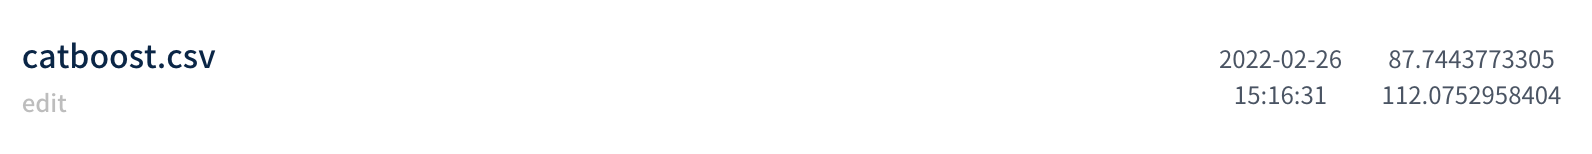

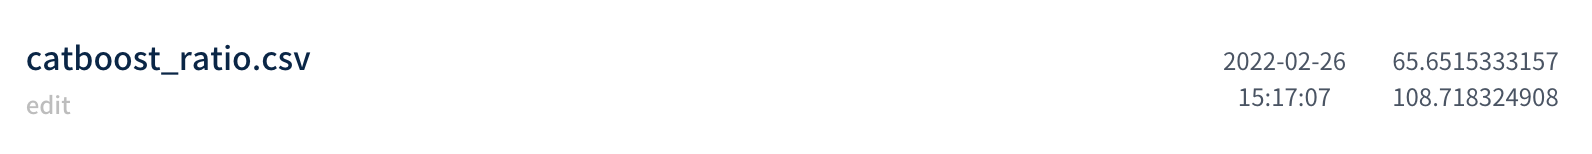

### XGBRegressor

In [ ]:
xgb1 = XGBRegressor(eta = 0.10407759844919826, 
                    max_depth = 4, 
                    n_estimator = 826, 
                    reg_lambda = 0.004012514673133838, 
                    alpha = 1.0985422191815084)
xgb2 = XGBRegressor(eta = 0.2563261004629465, 
                    max_depth = 3, 
                    n_estimator = 392, 
                    reg_lambda = 6.31710462619399, 
                    alpha = 0.0684781529856677)
xgb1.fit(train_lunch, lunch_target_ratio)
xgb2.fit(train_dinner, dinner_target_ratio)

pred_l_xgb = xgb1.predict(test_lunch)
pred_d_xgb = xgb2.predict(test_dinner)

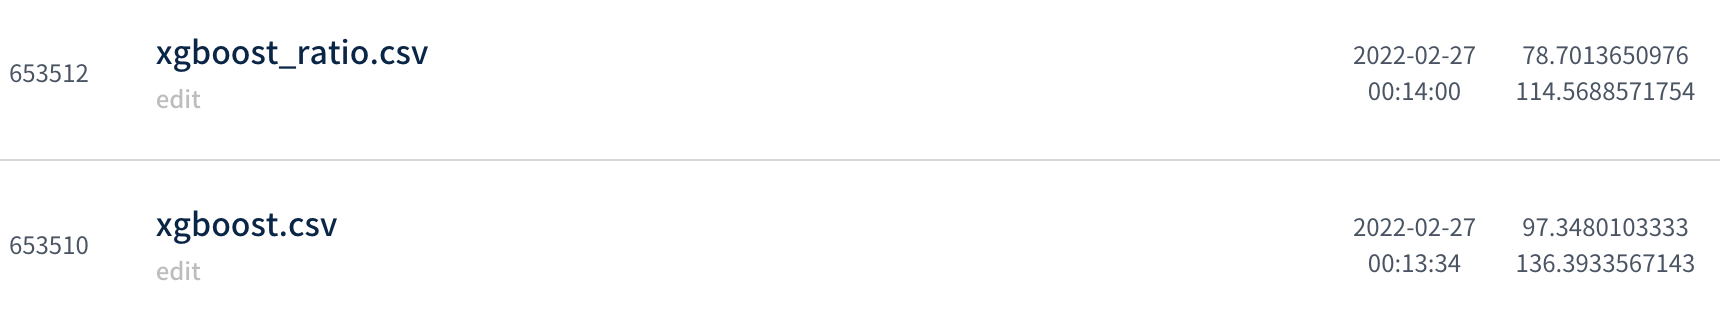

### GradientBoostingRegressor

In [ ]:
gbm1 = GradientBoostingRegressor(max_depth = 2, 
                                 n_estimators = 901, 
                                 learning_rate = 0.05, 
                                 subsample = 0.8, 
                                 min_samples_split = 4, 
                                 min_samples_leaf = 4)
gbm2 = GradientBoostingRegressor(max_depth = 3, 
                                 n_estimators = 576, 
                                 learning_rate = 0.02, 
                                 subsample = 0.6, 
                                 min_samples_split = 2, 
                                 min_samples_leaf = 1)
gbm1.fit(train_lunch, lunch_target_ratio)
gbm2.fit(train_dinner, dinner_target_ratio)

pred_l_gbm = gbm1.predict(test_lunch)
pred_d_gbm = gbm2.predict(test_dinner)

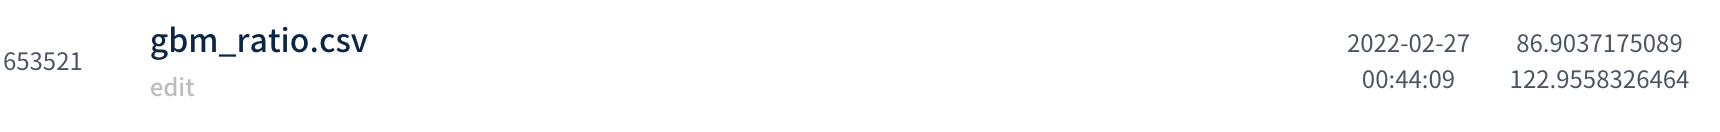

### NGBRegressor

In [ ]:
ngb1 = NGBRegressor(n_estimators = 703, 
                    learning_rate = 0.2, 
                    minibatch_frac = 0.6, 
                    col_sample = 0.8)
ngb2 = NGBRegressor(n_estimators = 1474, 
                    learning_rate = 0.15, 
                    minibatch_frac = 0.8, 
                    col_sample = 0.6)
ngb1.fit(train_lunch, lunch_target_ratio)
ngb2.fit(train_dinner, dinner_target_ratio)

pred_l_ngb = ngb1.predict(test_lunch)
pred_d_ngb = ngb2.predict(test_dinner)

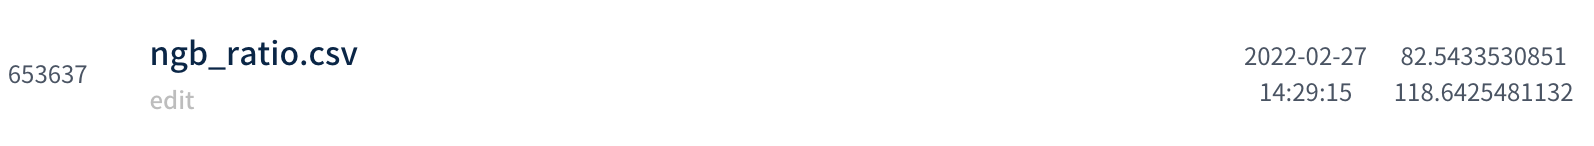

### LGBMRegressor

In [ ]:
lgbm1 = LGBMRegressor(n_estimators = 957, 
                      learning_rate = 0.05875244820384787, 
                      max_depth = 2, 
                      num_leaves = 14, 
                      subsample = 0.6, 
                      colsample = 1.0)
lgbm2 = LGBMRegressor(n_estimators = 2013, 
                      learning_rate = 0.0199698710226176, 
                      max_depth = 2, 
                      num_leaves = 9, 
                      subsample = 1.0, 
                      colsample = 0.6)
lgbm1.fit(train_lunch, lunch_target_ratio, verbose=0)
lgbm2.fit(train_dinner, dinner_target_ratio, verbose=0)

pred_l_lgbm = lgbm1.predict(test_lunch)
pred_d_lgbm = lgbm2.predict(test_dinner)

# sub['중식계'] = (0.5*pred_l_cat + 0.3*pred_l_xgb + 0.2*pred_l_lgbm) * test_lunch.reset_index(drop=True)['본사정원수']
# sub['석식계'] = (0.5*pred_d_cat + 0.3*pred_d_xgb + 0.2*pred_d_lgbm) * test_dinner.reset_index(drop=True)['본사정원수']
# sub.to_csv("./ensemble_ratio(C5X3L2).csv", index=False)

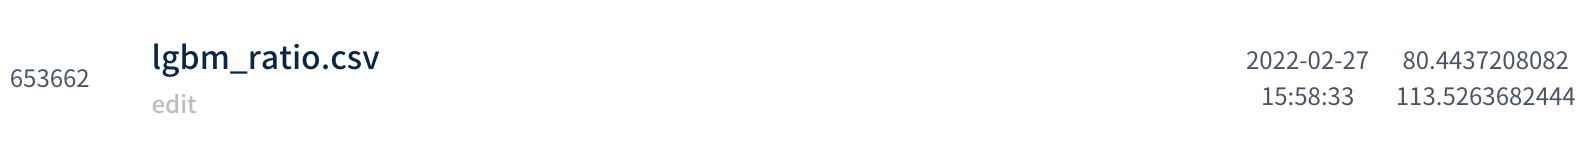

## 앙상블

In [ ]:
sub['중식계'] = (0.4*pred_l_cat + 0.3*pred_l_xgb + 0.3*pred_l_lgbm) * test_lunch.reset_index(drop=True)['본사정원수']
sub['석식계'] = (0.4*pred_d_cat + 0.3*pred_d_xgb + 0.3*pred_d_lgbm) * test_dinner.reset_index(drop=True)['본사정원수']
# sub.to_csv("./ensemble_ratio(C4X3L3).csv", index=False)

sub['중식계'] = (0.5*pred_l_cat + 0.3*pred_l_xgb + 0.2*pred_l_lgbm) * test_lunch.reset_index(drop=True)['본사정원수']
sub['석식계'] = (0.5*pred_d_cat + 0.3*pred_d_xgb + 0.2*pred_d_lgbm) * test_dinner.reset_index(drop=True)['본사정원수']
# sub.to_csv("./ensemble_ratio(C5X3L2).csv", index=False)

sub['중식계'] = (0.5*pred_l_cat + 0.3*pred_l_xgb + 0.2*pred_l_ngb) * test_lunch.reset_index(drop=True)['본사정원수']
sub['석식계'] = (0.5*pred_d_cat + 0.3*pred_d_xgb + 0.2*pred_d_ngb) * test_dinner.reset_index(drop=True)['본사정원수']
# sub.to_csv("./ensemble_ratio(C5X3N2).csv", index=False)

sub['중식계'] = (0.6*pred_l_cat + 0.4*pred_l_xgb) * test_lunch.reset_index(drop=True)['본사정원수']
sub['석식계'] = (0.6*pred_d_cat + 0.4*pred_d_xgb ) * test_dinner.reset_index(drop=True)['본사정원수']
# sub.to_csv("./ensemble_ratio(C6X4).csv", index=False)

sub['중식계'] = (0.7*pred_l_cat + 0.3*pred_l_xgb) * test_lunch.reset_index(drop=True)['본사정원수']
sub['석식계'] = (0.7*pred_d_cat + 0.3*pred_d_xgb ) * test_dinner.reset_index(drop=True)['본사정원수']
# sub.to_csv("./ensemble_ratio(C7X3).csv", index=False)

sub['중식계'] = (0.8*pred_l_cat + 0.2*pred_l_xgb) * test_lunch.reset_index(drop=True)['본사정원수']
sub['석식계'] = (0.8*pred_d_cat + 0.2*pred_d_xgb ) * test_dinner.reset_index(drop=True)['본사정원수']
# sub.to_csv("./ensemble_ratio(C8X2).csv", index=False)

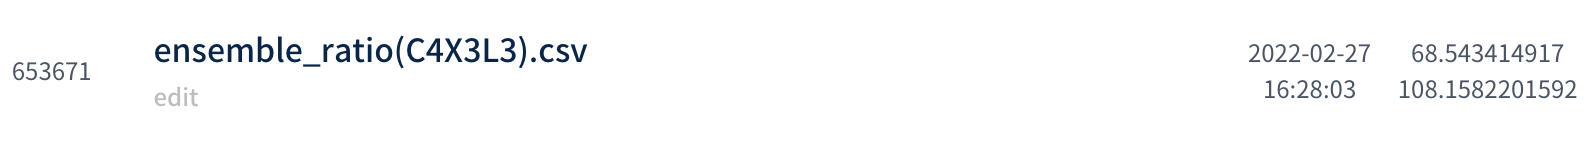

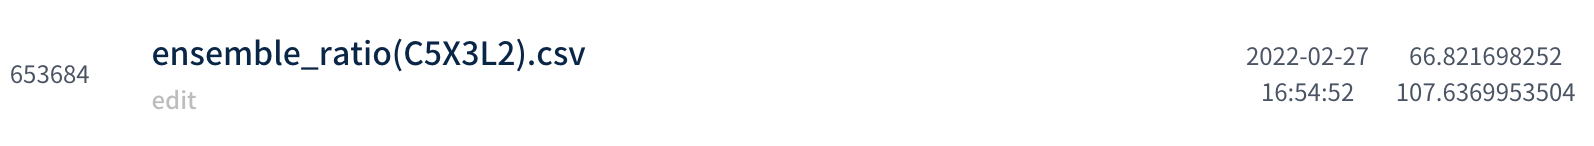

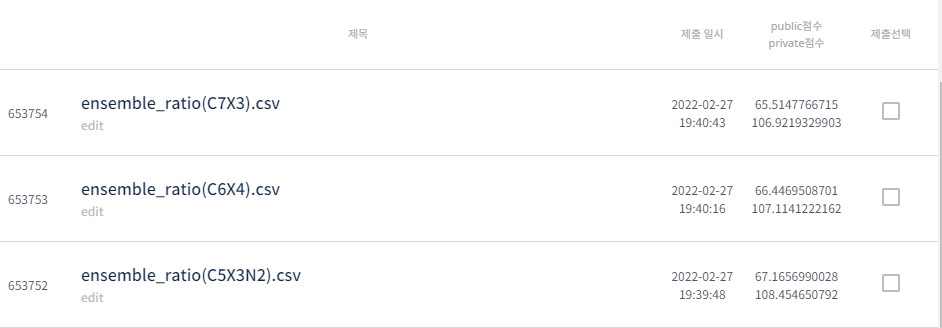